Loaded 500 rows and 10 columns

Training Random Forest…
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best RF params: {'rf__max_depth': 10, 'rf__n_estimators': 200}
RF R² = 0.429
RF MAE = € 7417406

Training HistGradientBoostingRegressor…
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best HGB params: {'hgb__learning_rate': 0.05, 'hgb__max_depth': None, 'hgb__max_iter': 200}
HGB R² = 0.308
HGB MAE = € 8403984

Computing permutation importances for HGB…
Saved HGB permutation importances to /images/hgb_with_rating_perm_importance.png


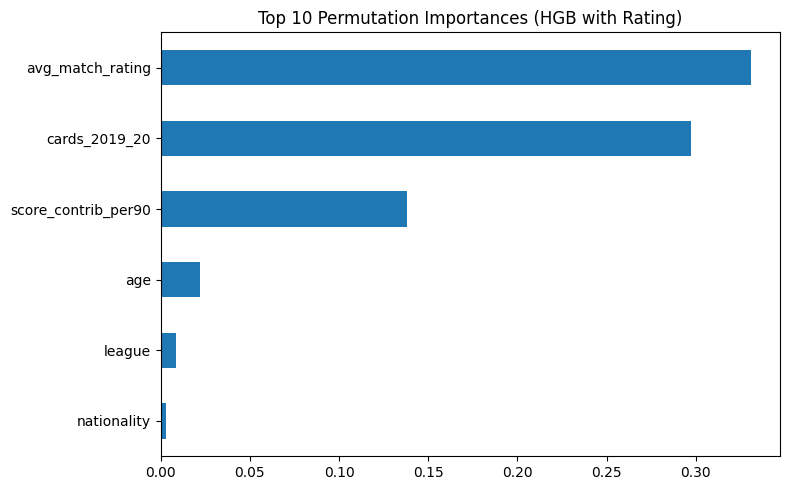

In [17]:
# src/07_ml_with_rating_fixed_importances.py

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection    import train_test_split, GridSearchCV
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import OneHotEncoder, StandardScaler
from sklearn.pipeline          import Pipeline
from sklearn.ensemble          import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics           import r2_score, mean_absolute_error
from sklearn.inspection         import permutation_importance

import matplotlib.pyplot as plt

# ─── 0) Paths ───────────────────────────────────────────────────────────────
ROOT     = Path(__file__).resolve().parent.parent
DATA_CSV = ROOT / "data" / "processed" / "players_2019_20_tidy500_with_avg_match_rating_v3.csv"
IMG_DIR  = ROOT / "images"
IMG_DIR.mkdir(exist_ok=True)

# ─── 1) Load data ──────────────────────────────────────────────────────────
df = pd.read_csv(DATA_CSV)
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns")

# ─── 2) Define features & target ────────────────────────────────────────────
num_feats = ["age", "score_contrib_per90", "cards_2019_20", "avg_match_rating"]
cat_feats = ["league", "nationality"]

X = df[num_feats + cat_feats]
y = df["market_value_eur"]

# ─── 3) Train/test split ────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ─── 4) Preprocessor ───────────────────────────────────────────────────────
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_feats),
])

# ─── 5) Random Forest pipeline ─────────────────────────────────────────────
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])
rf_params = {
    "rf__n_estimators": [200, 500],
    "rf__max_depth":    [10, 20, None],
}
rf_grid = GridSearchCV(
    rf_pipe, rf_params, cv=5, scoring="r2", n_jobs=-1, verbose=1
)

# ─── 6) HGB pipeline ────────────────────────────────────────────────────────
hgb_pipe = Pipeline([
    ("pre", preprocessor),
    ("hgb", HistGradientBoostingRegressor(random_state=42))
])
hgb_params = {
    "hgb__max_iter":      [200, 400],
    "hgb__learning_rate": [0.01, 0.05],
    "hgb__max_depth":     [None, 10, 20],
}
hgb_grid = GridSearchCV(
    hgb_pipe, hgb_params, cv=5, scoring="r2", n_jobs=-1, verbose=1
)

# ─── 7) Fit & evaluate Random Forest ───────────────────────────────────────
print("\nTraining Random Forest…")
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("Best RF params:", rf_grid.best_params_)
rf_pred = best_rf.predict(X_test)
# Use the built-in round() function instead of the method on the float object
print("RF R² =", round(r2_score(y_test, rf_pred), 3))
print("RF MAE = €", round(mean_absolute_error(y_test, rf_pred)))

# ─── 8) Fit & evaluate HGB ────────────────────────────────────────────────
print("\nTraining HistGradientBoostingRegressor…")
hgb_grid.fit(X_train, y_train)
best_hgb = hgb_grid.best_estimator_
print("Best HGB params:", hgb_grid.best_params_)
hgb_pred = best_hgb.predict(X_test)
# Use the built-in round() function instead of the method on the float object
print("HGB R² =", round(r2_score(y_test, hgb_pred), 3))
print("HGB MAE = €", round(mean_absolute_error(y_test, hgb_pred)))

# ─── 9) Permutation importances (HGB) ─────────────────────────────────────
print("\nComputing permutation importances for HGB…")
perm = permutation_importance(
    best_hgb, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)
feat_names = num_feats + cat_feats
imp_means  = perm.importances_mean
imp_series  = pd.Series(imp_means, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
imp_series.head(10).plot.barh()
plt.gca().invert_yaxis()
plt.title("Top 10 Permutation Importances (HGB with Rating)")
plt.tight_layout()
plt.savefig(IMG_DIR / "hgb_with_rating_perm_importance.png")
print(f"Saved HGB permutation importances to {IMG_DIR/'hgb_with_rating_perm_importance.png'}")